# Examples and Exercises from Think Stats, 2nd Edition

http://thinkstats2.com

Copyright 2016 Allen B. Downey

MIT License: https://opensource.org/licenses/MIT


In [1]:
from __future__ import print_function, division

%matplotlib inline
%load_ext autoreload
%autoreload 2
%matplotlib inline

import matplotlib.pyplot as plt
import mythinkstats as mts
import numpy as np
import pandas as pd
import scipy.stats

print('Ready')

Ready


I'll start with the data from the BRFSS again.

In [2]:
mfwghts = mts.brfss_read_data('ThinkStats2/code/CDBRFS08.ASC.gz')

Here are the mean and standard deviation of female height in cm.

In [3]:
female = mfwghts[mfwghts.sex == 2]
female_heights = female.htm3.dropna()
mean, std = female_heights.mean(), female_heights.std()
mean, std

(163.22347500412215, 7.269156286642232)

`NormalPdf` returns a Pdf object that represents the normal distribution with the given parameters.

`Density` returns a probability density, which doesn't mean much by itself.

In [4]:
p = {'loc': mean, 'scale': std}
pdf = scipy.stats.norm
pdf.pdf(mean + std, **p)

0.033287319047437085

`thinkplot` provides `Pdf`, which plots the probability density with a smooth curve.

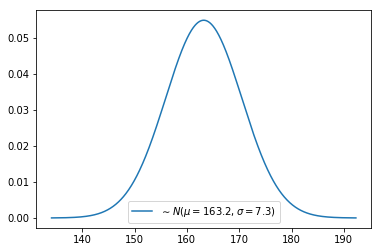

In [5]:
X = np.linspace(mean - 4*std, mean + 4*std, 1000)
plt.plot(X, pdf.pdf(X, **p), label='$\sim N(\mu=%.1lf,\sigma=%.1lf)$' % (mean, std))
plt.legend()
plt.show()

`Pdf` provides `MakePmf`, which returns a `Pmf` object that approximates the `Pdf`. 

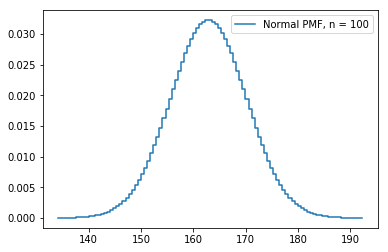

In [6]:
X = np.linspace(mean - 4*std, mean + 4*std, 100)
P = pdf.pdf(X, **p)
pmf = pd.Series(P, index=X) / sum(P)
plt.step(pmf.index, pmf.values, label='Normal PMF, n = %d' % len(X))
plt.legend()
plt.show()

If you have a `Pmf`, you can also plot it using `Pdf`, if you have reason to think it should be represented as a smooth curve.

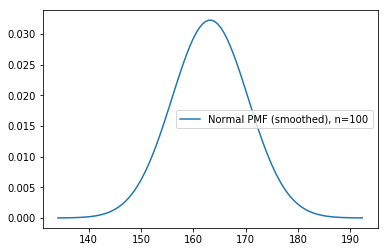

In [7]:
# This is literally just the difference between using plt.plot (smooth) and plt.step (step).
plt.plot(pmf.index, pmf.values, label='Normal PMF (smoothed), n=%d' % len(pmf))
plt.legend()
plt.show()

Using a sample from the actual distribution, we can estimate the PDF using Kernel Density Estimation (KDE).

If you run this a few times, you'll see how much variation there is in the estimate.

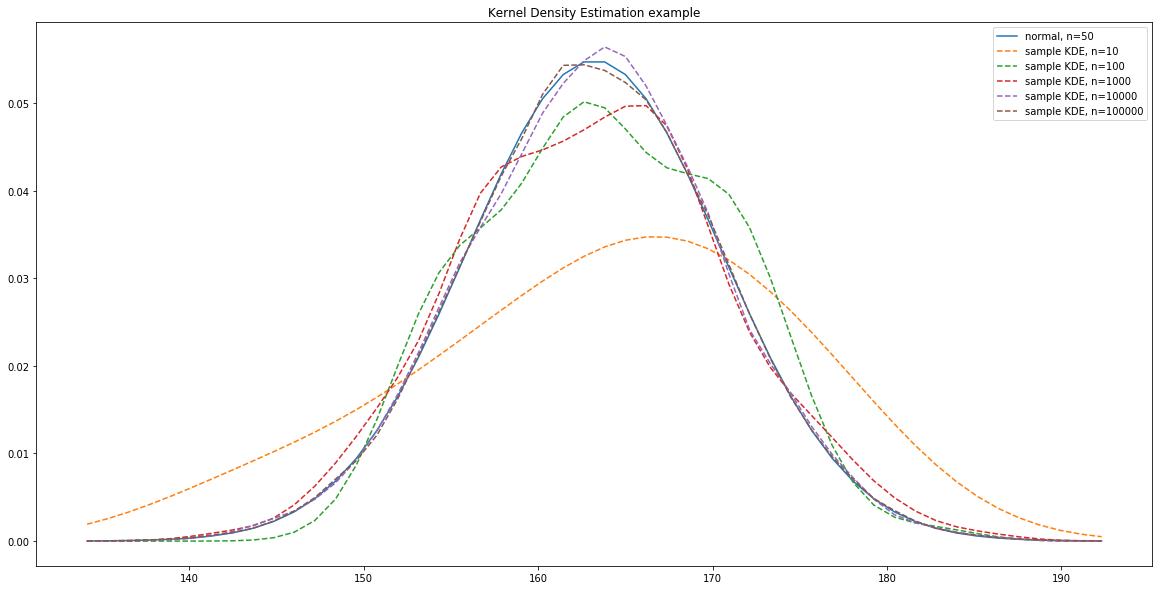

In [8]:
plt.figure(figsize=(20, 10))

# Plot the normal pdf.
X = np.linspace(mean - 4*std, mean + 4*std)
D = pdf.pdf(X, **p)
plt.plot(X, D, label='normal, n=%d' % len(X))

for n in np.arange(1, 6):
    # Plot a sample with KDE interpolation.
    smp = np.random.normal(mean, std, 10**n)
    kde = scipy.stats.gaussian_kde(smp)
    plt.plot(X, kde.evaluate(X), linestyle='--', label='sample KDE, n=%d' % 10**n)

plt.title('Kernel Density Estimation example')
plt.legend()
plt.show()

## Moments

Raw moments are just sums of powers.

In [9]:
def kth_moment(X, k):
    return sum(X**k) / len(X)

The first raw moment is the mean.  The other raw moments don't mean much.

In [10]:
for k in [1,2,3]:
    print('moment k=%d: %.2lf' % (k, kth_moment(female_heights, k)))

moment k=1: 163.22
moment k=2: 26694.74
moment k=3: 4374411.46


In [11]:
mean = lambda X: kth_moment(X, 1)
round(mean(female_heights), 2)

163.22

The central moments are powers of distances from the mean.

In [12]:
def central_moment(X, k):
    x_bar = kth_moment(X, 1)
    return sum((X - x_bar)**k) / len(X)

The first central moment is approximately 0.  The second central moment is the variance.

In [13]:
for k in [1,2,3]:
    print('central moment k=%d: %.2lf' % (k, central_moment(female_heights, k)))

central moment k=1: -0.00
central moment k=2: 52.84
central moment k=3: -46.89


In [14]:
variance = lambda X: central_moment(X, 2)
round(variance(female_heights), 2)

52.84

The standardized moments are ratios of central moments, with powers chosen to make the dimensions cancel.

In [15]:
def std_moment(X, k):
    std = np.sqrt(central_moment(X, 2))
    return central_moment(X, k) / std**k

The third standardized moment is skewness.

In [16]:
for k in [1,2,3]:
    print('standardized moment k=%d: %.2lf' % (k, std_moment(female_heights, k)))

standardized moment k=1: -0.00
standardized moment k=2: 1.00
standardized moment k=3: -0.12


In [17]:
skewness = lambda X: std_moment(X, 3)
round(skewness(female_heights), 2)

-0.12

Normally a negative skewness indicates that the distribution has a longer tail on the left.  In that case, the mean is usually less than the median.

In [18]:
def median(X):
    pmf = pd.Series(X).value_counts(normalize=True)
    cdf = mts.pmf_to_cdf(pmf)
    return mts.cdf_percentile(cdf, 0.5)

But in this case the mean is greater than the median, which indicates skew to the right.

In [19]:
mean(female_heights), median(female_heights)

(163.22347500412215, 163.0)

Because the skewness is based on the third moment, it is not robust; that is, it depends strongly on a few outliers.  Pearson's median skewness is more robust.

In [20]:
def pearson_median_skewness(X):
    median = X.median()
    mean = X.mean()
    std = X.std()
    return 3 * (mean - median) / std

Pearson's skewness is positive, indicating that the distribution of female heights is slightly skewed to the right.

In [21]:
# Skewness indicates which direction a distribution skews (positive = right, negative = left).
# Skewness increases a lot when you add a large outlier (very heavy weight).
# The pearson median skewness increases, but much less, when adding an outlier.
female_heights_with_outlier = female_heights.append(pd.Series([2 * max(female_heights)]))
print('Skewness, no outliers = %.3lf' % skewness(female_heights))
print('Skewness, w/ outlier = %.3lf' % skewness(female_heights_with_outlier))
print('Pearson median skewness, no outlier = %.5lf' % pearson_median_skewness(female_heights))
print('Pearson median skewness, w/ outlier = %.5lf' % pearson_median_skewness(female_heights_with_outlier))

Skewness, no outliers = -0.122
Skewness, w/ outlier = 0.138
Pearson median skewness, no outlier = 0.09223
Pearson median skewness, w/ outlier = 0.09241


## Birth weights

Let's look at the distribution of birth weights again.

In [22]:
preg = mts.nsfg_read_data('ThinkStats2/code/2002FemPreg.dct', 'ThinkStats2/code/2002FemPreg.dat.gz')
live = preg[preg.outcome == 1]
first = live[live.birthord == 1]
other = live[live.birthord > 1]
len(live), len(first), len(other)

(9148, 4413, 4735)

Based on KDE, it looks like the distribution is skewed to the left.

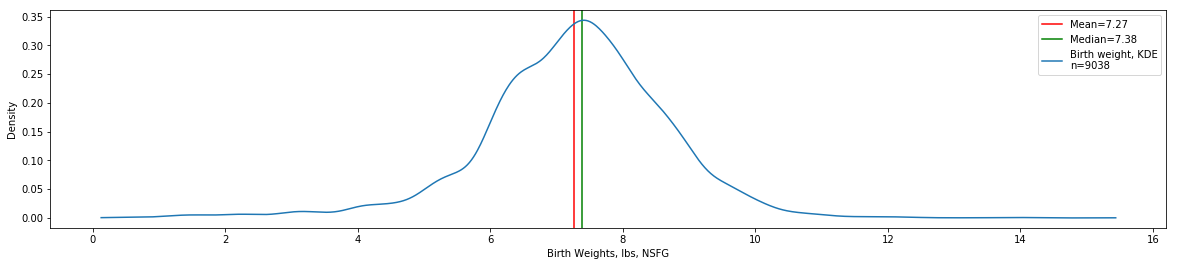

In [23]:
birth_weights = live.totalwgt_lb.dropna()
plt.figure(figsize=(20, 4))
plt.axvline(birth_weights.mean(), color='red', label='Mean=%.2lf' % birth_weights.mean())
plt.axvline(birth_weights.median(), color='green', label='Median=%.2lf' % birth_weights.median())
kde = scipy.stats.gaussian_kde(birth_weights.values)
X = np.linspace(min(birth_weights), max(birth_weights), 1001)
plt.plot(X, kde.evaluate(X), label='Birth weight, KDE\nn=%d' % len(birth_weights))
plt.xlabel('Birth Weights, lbs, NSFG')
plt.ylabel('Density')
plt.legend()
plt.show()

The mean is less than the median, which is consistent with left skew.

And both ways of computing skew are negative, which is consistent with left skew.

In [24]:
print('Skewness = %.2lf' % skewness(birth_weights))
print('Pearson skewness = %.2lf' % pearson_median_skewness(birth_weights))

Skewness = -0.59
Pearson skewness = -0.23


## Adult weights

Now let's look at adult weights from the BRFSS.  The distribution looks skewed to the right.

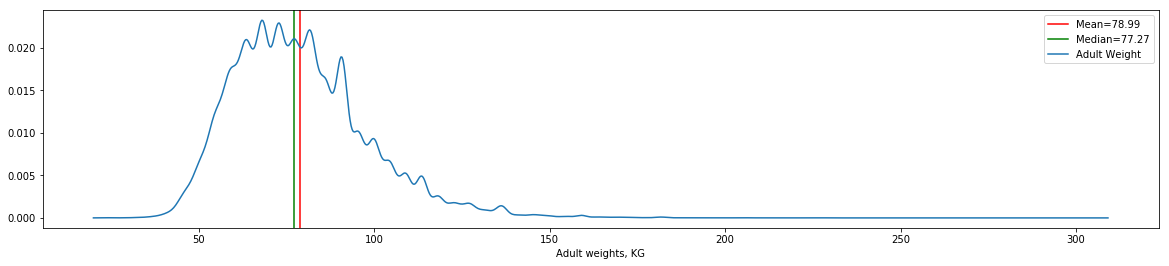

In [25]:
adult_weights = mfwghts.wtkg2.dropna()
kde = scipy.stats.gaussian_kde(adult_weights.values)
X = np.linspace(min(adult_weights), max(adult_weights), 1001)
P = kde.evaluate(X)
plt.figure(figsize=(20, 4))
plt.axvline(adult_weights.mean(), color='red', label='Mean=%.2lf' % adult_weights.mean())
plt.axvline(adult_weights.median(), color='green', label='Median=%.2lf' % adult_weights.median())
plt.plot(X, P, label='Adult Weight')
plt.xlabel('Adult weights, KG')
plt.legend()
plt.show()

The mean is greater than the median, which is consistent with skew to the right.

And both ways of computing skewness are positive.

In [26]:
print('Skewness = %.2lf' % skewness(adult_weights))
print('Pearson skewness = %.2lf' % pearson_median_skewness(adult_weights))

Skewness = 1.05
Pearson skewness = 0.26


## Exercises

The distribution of income is famously skewed to the right. In this exercise, we’ll measure how strong that skew is.
The Current Population Survey (CPS) is a joint effort of the Bureau of Labor Statistics and the Census Bureau to study income and related variables. Data collected in 2013 is available from http://www.census.gov/hhes/www/cpstables/032013/hhinc/toc.htm. I downloaded `hinc06.xls`, which is an Excel spreadsheet with information about household income, and converted it to `hinc06.csv`, a CSV file you will find in the repository for this book. You will also find `hinc2.py`, which reads this file and transforms the data.

The dataset is in the form of a series of income ranges and the number of respondents who fell in each range. The lowest range includes respondents who reported annual household income “Under \$5000.” The highest range includes respondents who made “\$250,000 or more.”

To estimate mean and other statistics from these data, we have to make some assumptions about the lower and upper bounds, and how the values are distributed in each range. `hinc2.py` provides `InterpolateSample`, which shows one way to model this data. It takes a `DataFrame` with a column, `income`, that contains the upper bound of each range, and `freq`, which contains the number of respondents in each frame.

It also takes `log_upper`, which is an assumed upper bound on the highest range, expressed in `log10` dollars. The default value, `log_upper=6.0` represents the assumption that the largest income among the respondents is $10^6$, or one million dollars.

`InterpolateSample` generates a pseudo-sample; that is, a sample of household incomes that yields the same number of respondents in each range as the actual data. It assumes that incomes in each range are equally spaced on a `log10` scale.

In [27]:
def income_log_samples(incomes, freqs, log_min=3, log_max=6.0):
    his = np.log10(incomes)
    los = np.roll(his, 1)
    los[0] = log_min
    his[-1] = log_max
    samples = np.concatenate([
        np.linspace(lo, hi, freq) for hi, lo, freq in zip(his, los, freqs)])
    return samples

In [28]:
wealth = mts.hinc_read_data('ThinkStats2/code/hinc06.csv')
wealth.head(10)

,income,freq,cumsum,ps
0,4999.0,4204,4204,0.034330
1,9999.0,4729,8933,0.072947
2,14999.0,6982,15915,0.129963
3,19999.0,7157,23072,0.188407
4,24999.0,7131,30203,0.246640
5,29999.0,6740,36943,0.301679
6,34999.0,6354,43297,0.353566
7,39999.0,5832,49129,0.401191
8,44999.0,5547,54676,0.446488
9,49999.0,5254,59930,0.489392


In [29]:
log_sample = income_log_samples(wealth.income.values, wealth.freq.values)

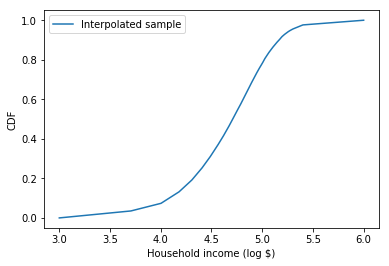

In [30]:
log_sample_pmf = pd.Series(log_sample).value_counts(normalize=True)
log_sample_cdf = mts.pmf_to_cdf(log_sample_pmf)
log_sample_cdf

plt.plot(log_sample_cdf.index, log_sample_cdf.values, label='Interpolated sample')
plt.ylabel('CDF')
plt.xlabel('Household income (log $)')
plt.legend()
plt.show()

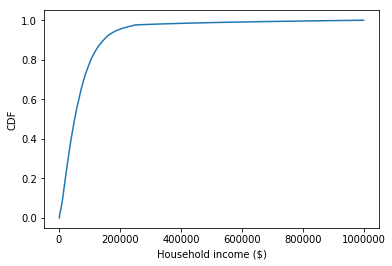

In [31]:
sample = np.power(10, log_sample)
sample_pmf = pd.Series(sample).value_counts(normalize=True)
sample_cdf = mts.pmf_to_cdf(sample_pmf)

plt.plot(sample_cdf.index, sample_cdf.values, label='Interpolated sample')
plt.xlabel('Household income ($)')
plt.ylabel('CDF')
plt.show()

Compute the median, mean, skewness and Pearson’s skewness of the resulting sample. What fraction of households report a taxable income below the mean? How do the results depend on the assumed upper bound?

In [32]:
# Solution goes here
for log_max in range(5, 9):
    sample = 10 ** income_log_samples(wealth.income.values, wealth.freq.values, log_max=log_max)
    sample = pd.Series(sample)
    print('Max income = %d (10^%d)' % (10 ** log_max, log_max))
    print('mean=%.2lf, median=%.2lf, skewness=%.2lf, pearson-skewness=%.2lf\n' % (
        sample.mean(), sample.median(), skewness(sample), pearson_median_skewness(sample)))

Max income = 100000 (10^5)
mean=65309.00, median=51226.93, skewness=1.18, pearson-skewness=0.81

Max income = 1000000 (10^6)
mean=74278.71, median=51226.93, skewness=4.95, pearson-skewness=0.74

Max income = 10000000 (10^7)
mean=124267.40, median=51226.93, skewness=11.60, pearson-skewness=0.39

Max income = 100000000 (10^8)
mean=457453.49, median=51226.93, skewness=14.89, pearson-skewness=0.27



All of this is based on an assumption that the highest income is one million dollars, but that's certainly not correct.  What happens to the skew if the upper bound is 10 million?

Without better information about the top of this distribution, we can't say much about the skewness of the distribution.

- As you increase the upper bound, skewness increases and pearson-skewness decreases.
- Skewness changes have a greater magnitude than the pearson-skewness changes.

In [33]:
print('Done')

Done
